## Logistic Regression to Predict High or Low Traffic Accident Severity

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [6]:
data = pd.read_csv('C:/data/Accidents.csv')

In [7]:
# Reduce traffic Severity from four categories down to two for Logistic Regression
data['SeverityLoHi'] = data['Severity'].apply(lambda x: 1 if x >= 3 else 0)

In [18]:
# Convert Civil Twilight from Day Night to 0 1
data['Day_Night'] = data['Civil_Twilight'].apply(lambda x: 1 if x == 'Night' else 0)

Text(0.5, 1.0, 'Low vs High Severity Accident Counts')

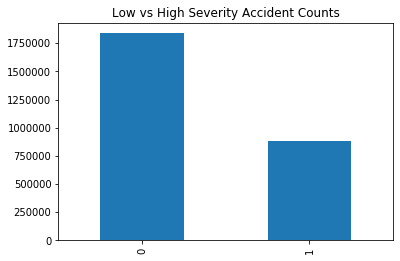

In [9]:
# Twice as many Low Severity Accidents vs. High Severity
data.SeverityLoHi.value_counts().plot(kind='bar')
plt.title('Low vs High Severity Accident Counts')


In [20]:
subset = data.drop(['Weather_Timestamp', 'Weather_Condition', 'ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Description', 'Wind_Direction', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode', 'Zip2', 'Country', 'Timezone', 'Airport_Code', 'Duration', 'Month', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'], axis = 1)

In [21]:
subset = pd.get_dummies(data = subset, columns = ['Weather_Group', 'weekday', 'hour'] )

In [23]:
subset.columns

Index(['Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Duration(m)',
       'SeverityLoHi', 'Day_Night', 'Weather_Group_Clear',
       'Weather_Group_Cloudy', 'Weather_Group_Heavy Precip',
       'Weather_Group_Light Precip', 'Weather_Group_Obscured',
       'Weather_Group_Windy', 'weekday_Fri', 'weekday_Mon', 'weekday_Sat',
       'weekday_Sun', 'weekday_Thu', 'weekday_Tue', 'weekday_Wed', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [24]:
steps = [('scaler', StandardScaler()), ('logreg', LogisticRegression())]

In [25]:
pipeline = Pipeline(steps)

In [26]:
# Create arrays for the features and the response variable
y = subset['SeverityLoHi'].values
X = subset.drop('SeverityLoHi', axis=1).values

In [27]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

In [28]:
logreg_scaled = pipeline.fit(X_train, y_train)

In [29]:
y_pred = pipeline.predict(X_test)

In [30]:
accuracy_score(y_test, y_pred)

0.6944069801888199

In [34]:
# 5-fold cross-validation scores
cv_scores = cross_val_score(pipeline, X, y, cv=5)

In [37]:
print(cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[0.69358818 0.6947529  0.69213827 0.68903789 0.69176419]
Average 5-Fold CV Score: 0.6922562855975413


In [32]:
print(confusion_matrix(y_test, y_pred))

[[345447  22419]
 [143665  31950]]


False positives in the lower left corner appear to drive the inaccuracy

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.94      0.81    367866
           1       0.59      0.18      0.28    175615

    accuracy                           0.69    543481
   macro avg       0.65      0.56      0.54    543481
weighted avg       0.67      0.69      0.64    543481



The high recall for 0 is an indication most low-severity traffic accidents were predicted correctly.

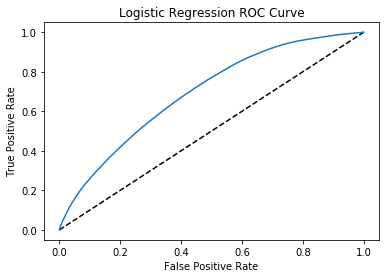

In [38]:
# Plotting the ROC curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title('Logistic Regression ROC Curve')
plt.show()

In [39]:
roc_auc_score(y_test, y_pred_prob)

0.6925442855104512

In [41]:
# Hyperparameter tuning with GridSearchCV
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
logreg_cv = GridSearchCV(pipeline, param_grid, cv=5)
logreg_cv.fit(X, y)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))

ValueError: Invalid parameter C for estimator Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.